In [1]:
# Standard library
import os
import tempfile
import uuid
from pathlib import Path

# Third-party libraries
from filelock import FileLock
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchmetrics.classification import Accuracy

# torchvision (separate for clarity)
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms

# Ray imports
import ray
from ray.train.torch import TorchTrainer
from ray.train import ScalingConfig, RunConfig, CheckpointConfig

In [2]:
data = CIFAR10(root="../marimo_notebooks/data",download=True,train=False)
data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../marimo_notebooks/data
    Split: Test

In [3]:
# the data contains of a PIL image and the label
next(iter(data))

(<PIL.Image.Image image mode=RGB size=32x32>, 3)

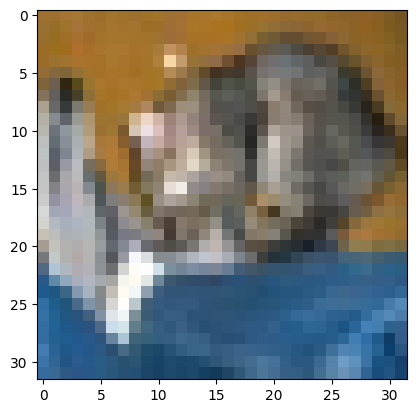

In [4]:
plt.imshow(next(iter(data))[0])

In [5]:
class_to_idx = data.class_to_idx
class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [6]:
weights = ResNet18_Weights.IMAGENET1K_V1

In [7]:
model = resnet18(weights=ResNet18_Weights)
model

/home/ray/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
def create_transforms():
    train_transform = transforms.Compose([
        transforms.Resize((150,150)),
        transforms.RandomCrop((128,128)),
        transforms.RandomHorizontalFlip(p=0.2),
        transforms.ColorJitter(brightness=0.1,contrast=0.1,saturation=0.1,hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) #-> [0,1] -> [-1,1] 
        
    ])

    valid_transform = transforms.Compose([
        transforms.Resize((150,150)),
        transforms.CenterCrop((128,128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) #-> [0,1] -> [-1,1] 
        
    ])
    return train_transform, valid_transform

In [9]:
def get_cifar_dataloader(batch_size):
    weights = ResNet18_Weights.IMAGENET1K_V1
    resnet18_transforms = weights.transforms()
    train_transform, valid_transform  = create_transforms()
    with FileLock(os.path.expanduser("~/cifar_data.lock")):
        train = CIFAR10(
            root="~/cifar_data",
            train=True,
            download=True,
            transform=resnet18_transforms,
        )
        valid = CIFAR10(
            root="~/cifar_data",
            train=False,
            download=True,
            transform=resnet18_transforms,
        )
    #train_sub = Subset(train,indices=range(1000))
    #valid_sub = Subset(valid,indices=range(1000))
    # dataloaders to get data in batches
    train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(valid, batch_size=batch_size)

    return train_dataloader, valid_dataloader



In [10]:
sample_dataloader = next(iter(get_cifar_dataloader(3)))
single_batch =  next(iter(sample_dataloader))

In [11]:
single_batch[1].shape

torch.Size([3])

In [12]:
single_batch[0].shape

torch.Size([3, 3, 224, 224])

In [13]:
def train_func(config):

    epochs = config["epochs"]
    batch_size = config["batch_size"]
    lr = config["lr"]
    
    
    # use detected device
    device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

    # metrics
    accuracy = Accuracy(task="multiclass", num_classes=config["num_classes"]).to(device)
    
    device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    weights = ResNet18_Weights.IMAGENET1K_V1


    # freezing the all weights except the last one
    model = resnet18(weights=weights)
    # for parameter in model.parameters():
    #     parameter.requires_grad = False

    # outputs 10 classes
    model.fc = nn.Linear(512,config["num_classes"],bias=True)
    # prepare model
    model = ray.train.torch.prepare_model(model)
 
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])

    train_dataloader, valid_dataloader = get_cifar_dataloader(batch_size=batch_size)
    train_dataloader = ray.train.torch.prepare_data_loader(train_dataloader)
    valid_dataloader = ray.train.torch.prepare_data_loader(valid_dataloader)

    for epoch in range(epochs):
        # checking if training is scheduled in a distributed setting or not.
        if ray.train.get_context().get_world_size() > 1:
            train_dataloader.sampler.set_epoch(epoch)
        train_loss = 0.0
        train_acc = 0.0
        num_total = 0.0
        num_correct = 0.0
        #num_batches = 0.0
        model.train()
        for idx, batch in enumerate(train_dataloader):
            x, y = batch[0], batch[1]
            y_preds = model(x)
            y_labels = y_preds.argmax(dim=1)
            loss = loss_fn(y_preds,y)
            acc = accuracy(y_labels,y)
            train_loss +=  loss.item()
            train_acc += acc.item()
        train_loss /=len(train_dataloader)
        train_acc /=len(train_dataloader)
        metrics = {"epoch":epoch,"train_loss":train_loss, "train_acc":train_acc}

        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            torch.save(
                model.module.state_dict(),
                os.path.join(temp_checkpoint_dir, "model.pt")
            )
            ray.train.report(
                metrics,
                checkpoint=ray.train.Checkpoint.from_directory(temp_checkpoint_dir),
            )

        if ray.train.get_context().get_world_rank() == 0:
            print(metrics)

In [14]:
global_batch_size = 300
num_workers = 3
use_gpu = True

train_config = {
    "lr": 0.01,
    "epochs": 3,
    "num_classes": 10,
    "batch_size": global_batch_size // num_workers,
    "weight_decay": 0.02
}
scaling_config = ScalingConfig(num_workers=num_workers, use_gpu=use_gpu)
run_config = RunConfig(
    storage_path="/mnt/cluster_storage", # we could use s3 as well
    name=f"ray_train_torch_run-{uuid.uuid4().hex}",
    checkpoint_config = CheckpointConfig(num_to_keep=1,
    checkpoint_score_attribute="train_acc",
    checkpoint_score_order="max",) 
)

trainer = TorchTrainer(
    train_loop_per_worker=train_func,
    train_loop_config=train_config,
    scaling_config=scaling_config,
    run_config=run_config,
)

2025-08-03 09:05:54,634	INFO worker.py:1747 -- Connecting to existing Ray cluster at address: 100.108.139.17:6379...
2025-08-03 09:05:54,646	INFO worker.py:1918 -- Connected to Ray cluster. View the dashboard at https://session-xsclvf1y3h8ri22vxrxzy7b516.i.anyscaleuserdata.com 
2025-08-03 09:05:54,649	INFO packaging.py:380 -- Pushing file package 'gcs://_ray_pkg_60dc8a092d79df86c771badaeada41af6c17e613.zip' (0.12MiB) to Ray cluster...
2025-08-03 09:05:54,650	INFO packaging.py:393 -- Successfully pushed file package 'gcs://_ray_pkg_60dc8a092d79df86c771badaeada41af6c17e613.zip'.


In [15]:
result = trainer.fit()
print(f"Training result: {result}")

2025-08-03 09:05:55,250	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


== Status ==
Current time: 2025-08-03 09:05:55 (running for 00:00:00.11)
Using FIFO scheduling algorithm.
Logical resource usage: 0/24 CPUs, 0/3 GPUs (0.0/1.0 anyscale/cpu_only:true, 0.0/4.0 anyscale/provider:aws, 0.0/4.0 anyscale/region:us-east-2, 0.0/1.0 anyscale/node-group:head, 0.0/3.0 anyscale/node-group:1xT4:8CPU-32GB, 0.0/3.0 anyscale/accelerator_shape:1xT4, 0.0/3.0 accelerator_type:T4)
Result logdir: /tmp/ray/session_2025-08-03_07-30-39_655412_2483/artifacts/2025-08-03_09-05-55/ray_train_torch_run-e4b622f8e1f74113b1d75fa68cf6ff73/driver_artifacts
Number of trials: 1/1 (1 PENDING)


(autoscaler +17s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
== Status ==
Current time: 2025-08-03 09:06:00 (running for 00:00:05.14)
Using FIFO scheduling algorithm.
Logical resource usage: 0/24 CPUs, 0/3 GPUs (0.0/1.0 anyscale/cpu_only:true, 0.0/4.0 anyscale/provider:aws, 0.0/4.0 anyscale/region:us-east-2, 0.0/1.0 anyscale/node-grou

(RayTrainWorker pid=4977, ip=100.90.215.82) Setting up process group for: env:// [rank=0, world_size=3]
(TorchTrainer pid=4895, ip=100.90.215.82) Started distributed worker processes: 
(TorchTrainer pid=4895, ip=100.90.215.82) - (node_id=4d68ed390060105286853ea9ec73313e42c08e9bf80bbc3288a189e5, ip=100.90.215.82, pid=4977) world_rank=0, local_rank=0, node_rank=0
(TorchTrainer pid=4895, ip=100.90.215.82) - (node_id=143f48506de8088ec7e36dc3ac878fea5b9e59c000730412700a8592, ip=100.104.168.4, pid=4895) world_rank=1, local_rank=0, node_rank=1
(TorchTrainer pid=4895, ip=100.90.215.82) - (node_id=454ae614fa641111af4f16fdd1cabcf75b3a440a5919e2be97329256, ip=100.93.167.84, pid=4968) world_rank=2, local_rank=0, node_rank=2


== Status ==
Current time: 2025-08-03 09:07:41 (running for 00:01:45.63)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/24 CPUs, 3.0/3 GPUs (0.0/4.0 anyscale/region:us-east-2, 0.0/1.0 anyscale/node-group:head, 0.0/1.0 anyscale/cpu_only:true, 0.0/4.0 anyscale/provider:aws, 0.0/3.0 anyscale/node-group:1xT4:8CPU-32GB, 0.0/3.0 anyscale/accelerator_shape:1xT4, 0.0/3.0 accelerator_type:T4)
Result logdir: /tmp/ray/session_2025-08-03_07-30-39_655412_2483/artifacts/2025-08-03_09-05-55/ray_train_torch_run-e4b622f8e1f74113b1d75fa68cf6ff73/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




(RayTrainWorker pid=4977, ip=100.90.215.82) Moving model to device: cuda:0
(RayTrainWorker pid=4977, ip=100.90.215.82) Wrapping provided model in DistributedDataParallel.


== Status ==
Current time: 2025-08-03 09:07:46 (running for 00:01:50.65)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/24 CPUs, 3.0/3 GPUs (0.0/1.0 anyscale/node-group:head, 0.0/4.0 anyscale/provider:aws, 0.0/4.0 anyscale/region:us-east-2, 0.0/1.0 anyscale/cpu_only:true, 0.0/3.0 accelerator_type:T4, 0.0/3.0 anyscale/node-group:1xT4:8CPU-32GB, 0.0/3.0 anyscale/accelerator_shape:1xT4)
Result logdir: /tmp/ray/session_2025-08-03_07-30-39_655412_2483/artifacts/2025-08-03_09-05-55/ray_train_torch_run-e4b622f8e1f74113b1d75fa68cf6ff73/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2025-08-03 09:07:51 (running for 00:01:55.67)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/24 CPUs, 3.0/3 GPUs (0.0/1.0 anyscale/node-group:head, 0.0/4.0 anyscale/provider:aws, 0.0/4.0 anyscale/region:us-east-2, 0.0/1.0 anyscale/cpu_only:true, 0.0/3.0 accelerator_type:T4, 0.0/3.0 anyscale/node-group:1xT4:8CPU-32GB, 0.0/3.0 anyscale/accelerator_shape:1xT4

(RayTrainWorker pid=4895, ip=100.104.168.4) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/mnt/cluster_storage/ray_train_torch_run-e4b622f8e1f74113b1d75fa68cf6ff73/TorchTrainer_100cc_00000_0_2025-08-03_09-05-55/checkpoint_000000)
(RayTrainWorker pid=4895, ip=100.104.168.4) Moving model to device: cuda:0 [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(RayTrainWorker pid=4895, ip=100.104.168.4) Wrapping provided model in DistributedDataParallel. [repeated 2x across cluster]
2025-08-03 09:08:38,254	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the la

(RayTrainWorker pid=4977, ip=100.90.215.82) {'epoch': 0, 'train_loss': 2.4220690441702653, 'train_acc': 0.09011707944561265}
== Status ==
Current time: 2025-08-03 09:08:41 (running for 00:02:45.89)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/24 CPUs, 3.0/3 GPUs (0.0/4.0 anyscale/region:us-east-2, 0.0/1.0 anyscale/node-group:head, 0.0/1.0 anyscale/cpu_only:true, 0.0/4.0 anyscale/provider:aws, 0.0/3.0 anyscale/node-group:1xT4:8CPU-32GB, 0.0/3.0 anyscale/accelerator_shape:1xT4, 0.0/3.0 accelerator_type:T4)
Result logdir: /tmp/ray/session_2025-08-03_07-30-39_655412_2483/artifacts/2025-08-03_09-05-55/ray_train_torch_run-e4b622f8e1f74113b1d75fa68cf6ff73/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2025-08-03 09:08:46 (running for 00:02:50.90)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/24 CPUs, 3.0/3 GPUs (0.0/4.0 anyscale/region:us-east-2, 0.0/1.0 anyscale/cpu_only:true, 0.0/1.0 anyscale/node-group:head, 0.0/4.0 anyscale/p

2025-08-03 09:09:21,517	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 


== Status ==
Current time: 2025-08-03 09:09:21 (running for 00:03:26.04)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/24 CPUs, 3.0/3 GPUs (0.0/4.0 anyscale/provider:aws, 0.0/1.0 anyscale/node-group:head, 0.0/1.0 anyscale/cpu_only:true, 0.0/4.0 anyscale/region:us-east-2, 0.0/3.0 accelerator_type:T4, 0.0/3.0 anyscale/accelerator_shape:1xT4, 0.0/3.0 anyscale/node-group:1xT4:8CPU-32GB)
Result logdir: /tmp/ray/session_2025-08-03_07-30-39_655412_2483/artifacts/2025-08-03_09-05-55/ray_train_torch_run-e4b622f8e1f74113b1d75fa68cf6ff73/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




2025-08-03 09:09:21,802	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/mnt/cluster_storage/ray_train_torch_run-e4b622f8e1f74113b1d75fa68cf6ff73' in 0.2833s.


== Status ==
Current time: 2025-08-03 09:09:21 (running for 00:03:26.32)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/24 CPUs, 3.0/3 GPUs (0.0/4.0 anyscale/provider:aws, 0.0/1.0 anyscale/node-group:head, 0.0/1.0 anyscale/cpu_only:true, 0.0/4.0 anyscale/region:us-east-2, 0.0/3.0 accelerator_type:T4, 0.0/3.0 anyscale/accelerator_shape:1xT4, 0.0/3.0 anyscale/node-group:1xT4:8CPU-32GB)
Result logdir: /tmp/ray/session_2025-08-03_07-30-39_655412_2483/artifacts/2025-08-03_09-05-55/ray_train_torch_run-e4b622f8e1f74113b1d75fa68cf6ff73/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


(RayTrainWorker pid=4977, ip=100.90.215.82) {'epoch': 1, 'train_loss': 2.4174113673364332, 'train_acc': 0.0882277238757132}


(RayTrainWorker pid=4977, ip=100.90.215.82) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/mnt/cluster_storage/ray_train_torch_run-e4b622f8e1f74113b1d75fa68cf6ff73/TorchTrainer_100cc_00000_0_2025-08-03_09-05-55/checkpoint_000001) [repeated 3x across cluster]
2025-08-03 09:09:30,629	INFO tune.py:1041 -- Total run time: 215.38 seconds (206.04 seconds for the tuning loop).
2025-08-03 09:09:30,630	WARNING tune.py:1051 -- Training has been interrupted, but the most recent state was saved.
Resume training with: <FrameworkTrainer>.restore(path="/mnt/cluster_storage/ray_train_torch_run-e4b622f8e1f74113b1d75fa68cf6ff73", ...)


Training result: Result(
  metrics={'epoch': 0, 'train_loss': 2.4220690441702653, 'train_acc': 0.09011707944561265},
  path='/mnt/cluster_storage/ray_train_torch_run-e4b622f8e1f74113b1d75fa68cf6ff73/TorchTrainer_100cc_00000_0_2025-08-03_09-05-55',
  filesystem='local',
  checkpoint=Checkpoint(filesystem=local, path=/mnt/cluster_storage/ray_train_torch_run-e4b622f8e1f74113b1d75fa68cf6ff73/TorchTrainer_100cc_00000_0_2025-08-03_09-05-55/checkpoint_000000)
)


(RayTrainWorker pid=4968, ip=100.93.167.84) [rank2]:[W803 09:09:30.252158576 TCPStore.cpp:125] [c10d] recvValue failed on SocketImpl(fd=42, addr=[ip-10-0-29-176]:56854, remote=[::ffff:100.90.215.82]:53151): failed to recv, got 0 bytes
(RayTrainWorker pid=4968, ip=100.93.167.84) Exception raised from recvBytes at /pytorch/torch/csrc/distributed/c10d/Utils.hpp:678 (most recent call first):
(RayTrainWorker pid=4968, ip=100.93.167.84) frame #0: c10::Error::Error(c10::SourceLocation, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >) + 0x98 (0x7793502c75e8 in /tmp/ray/session_2025-08-03_07-30-39_655412_2483/runtime_resources/pip/95827506fa75379904c3ce3b9ca4084a17838508/virtualenv/lib/python3.12/site-packages/torch/lib/libc10.so)
(RayTrainWorker pid=4968, ip=100.93.167.84) frame #1: <unknown function> + 0x5ba8bfe (0x7793307a8bfe in /tmp/ray/session_2025-08-03_07-30-39_655412_2483/runtime_resources/pip/95827506fa75379904c3ce3b9ca4084a17838508/virtualenv/lib/pytho

In [16]:
ray.shutdown()